In [4]:
library(HoneyBADGER)
library(biomaRt)
library(data.table)
library(dplyr)
library(ggplot2)
library(stringr)
library(parallel)
library(glue)

Loading required package: GenomicFeatures

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4




In [5]:
con = readRDS('~/external/WASHU/con.rds')
annot = fread('~/external/WASHU/sample_barcode_cell_type_annotation.txt')

cell_annot = annot %>% 
    mutate(sample_id = str_replace(sample_id, '-', '_')) %>%
    mutate(sample_id = ifelse(sample_id == '57075_Pre_transplant', '57075_Primary', sample_id)) %>%
    mutate(cell = paste0(sample_id, '_', barcode)) %>% 
    split(.$sample_id)

In [6]:
count_mat = c()
df = c()

mart.obj <- useMart(biomart = "ENSEMBL_MART_ENSEMBL", dataset = 'hsapiens_gene_ensembl')
library(TxDb.Hsapiens.UCSC.hg38.knownGene) ## in order to map SNPs to genes
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

gtf_transcript = numbat::gtf_hg38

In [7]:
samples = c('27522_Relapse_2', '58408_Primary', '47491_Primary', '37692_Primary', '59114_Relapse_1')

In [8]:
for (sample in samples) {
    count_mat[[sample]] = as.matrix(t(con$samples[[sample]]$misc$rawCounts))
    cells = intersect(cell_annot[[sample]]$cell, colnames(count_mat[[sample]]))
    cell_annot[[sample]] = cell_annot[[sample]] %>% filter(cell %in% cells)
    count_mat[[sample]] = count_mat[[sample]][,cells]
    df[[sample]] = fread(glue('~/external/WASHU/{sample}_allele_counts.tsv'), sep = '\t') %>%
        filter(cell %in% cells)
}

# Tumor HMM

In [ ]:
ref_types = c('NK', 'Macrophage', 'CD4+T', 'CD8+T', 'Myeloid', 'Monocyte', 'B', 'Plasma', 'Dendritic')

hb = c()

for (sample in samples) {
    
    message(sample)

    if (sample == '27522_Relapse_2') {
        clusters = con$samples[[sample]]$clusters$PCA$multilevel
        clusters = clusters[names(clusters) %in% cell_annot[[sample]]$cell]

        cells = cell_annot[[sample]] %>% 
            mutate(cluster = clusters[cell]) %>%
            filter(cell_type == 'Plasma' & cluster == 4) %>% pull(cell)
    } else {
        cells = cell_annot[[sample]] %>% filter(cell_type == 'Plasma') %>% pull(cell)
    }

    cm = count_mat[[sample]][,cells] 
    exp_mat = scale(cm, center=FALSE, scale=colSums(cm)) 
    
    hb[[sample]] <- new('HoneyBADGER', name='test')
    hb[[sample]]$setGexpMats(log(exp_mat * 1e6 + 1), log(rowMeans(numbat::ref_hca[,ref_types]) * 1e6 + 1), mart.obj, filter=TRUE, scale=TRUE, verbose=TRUE)
    
    alt.counts = df[[sample]] %>% 
        filter(CHROM != 'X') %>%
        filter(GT %in% c('0|1', '1|0')) %>%
        filter(cell %in% cells) %>% 
        mutate(snp_id = paste0(CHROM, ':', POS)) %>%
        mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
        distinct(cell, snp_id, .keep_all = TRUE) %>%
        dcast(snp_id ~ cell, value.var = 'AD', fill = 0) %>%
        tibble::column_to_rownames('snp_id') %>%
        as.matrix

    total.counts = df[[sample]] %>%
        filter(CHROM != 'X') %>%
        filter(GT %in% c('0|1', '1|0')) %>%
        filter(cell %in% cells) %>% 
        mutate(snp_id = paste0(CHROM, ':', POS)) %>%
        mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
        distinct(cell, snp_id, .keep_all = TRUE) %>%
        dcast(snp_id ~ cell, value.var = 'DP', fill = 0) %>%
        tibble::column_to_rownames('snp_id') %>%
        as.matrix

    ## Add to existing hb object
    hb[[sample]]$setAlleleMats(r.init=alt.counts, n.sc.init=total.counts, het.deviance.threshold = -1, n.cores=20)
    hb[[sample]]$setGeneFactors(txdb)
}

Initializing expression matrices ... 
11847 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 11847 genes and 224 cells ... 
Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 224 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
31000 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-22 10:26:32 AM 
>> identifying nearest features...		 2021-12-22 10:26:32 AM 
>> calculating distance from peak to TSS...	 2021-12-22 10:26:33 AM 
>> assigning genomic annotation...		 2021-12-22 10:26:33 AM 
>> assigning chromosome lengths			 2021-12-22 10:26:34 AM 
>> done...					 2021-12-22 10:26:34 AM 
Done mapping snps to genes! 
Initializing ex


Batch submitting query [=========>---------------------]  33% eta: 14s

Batch submitting query [====================>----------]  67% eta:  5s
                                                                      



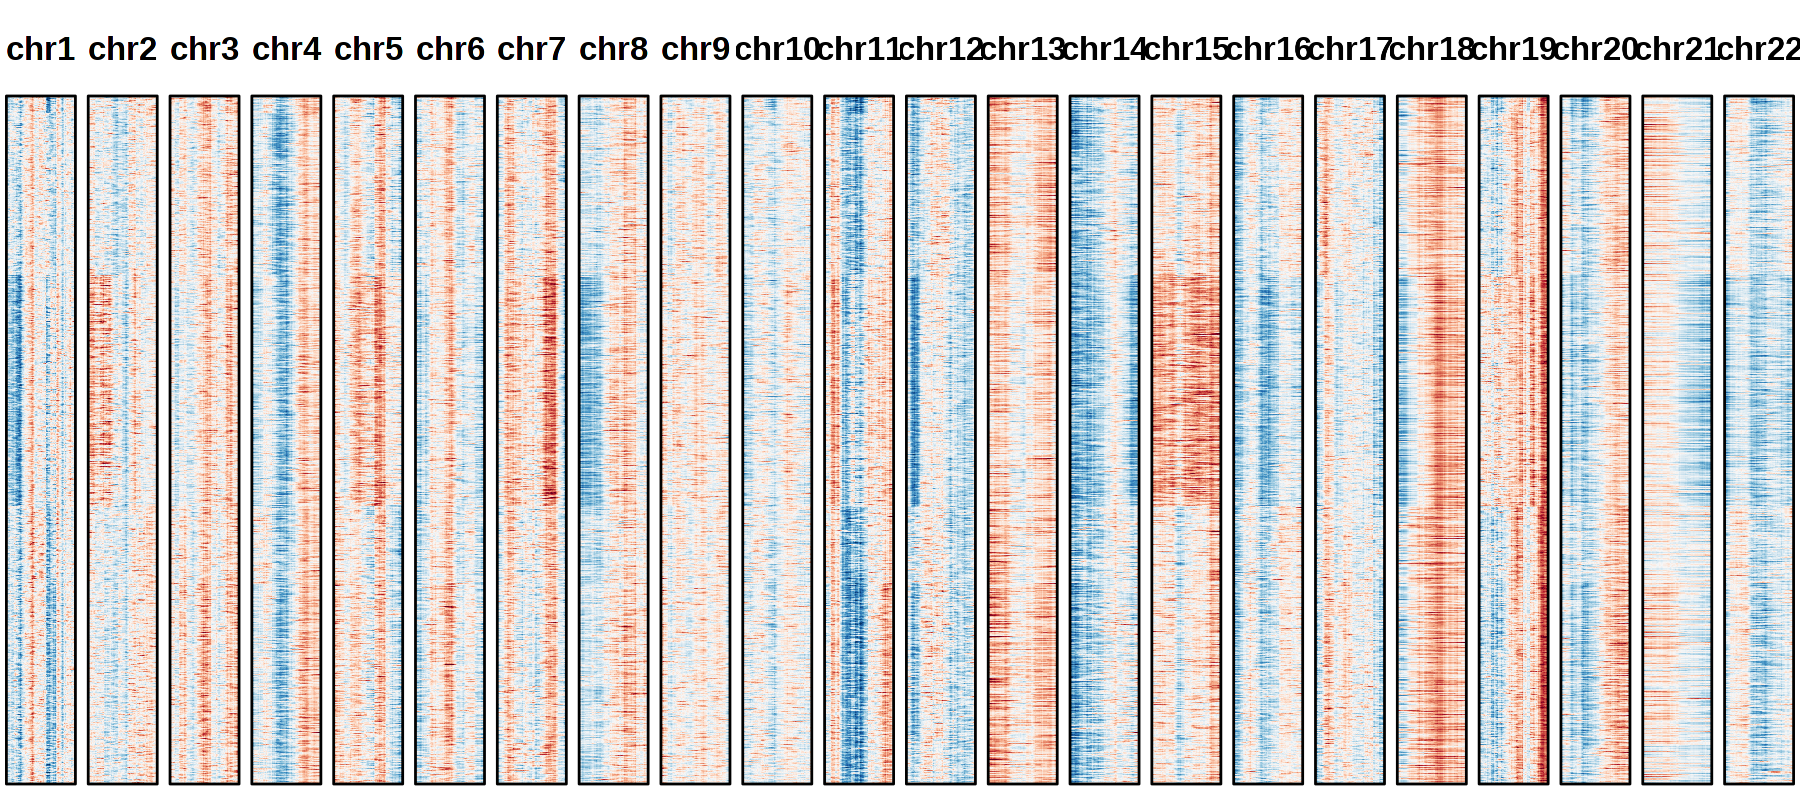

In [558]:
options(repr.plot.width = 9, repr.plot.height = 4, repr.plot.res = 200)

hb_full[['47491_Primary']]$plotGexpProfile(zlim = c(-0.5,0.5))

In [13]:
run_exp_hmm = function(hb, t = 1e-3, m = 0.15) {
    
    mat.smooth <- apply(hb$gexp.norm, 1, mean)

#     m = 0.15
#     t = 1e-3
    ## change point
    delta <- c(0, 1, 0)
    t <- t
    pd <- -m
    pn <- 0
    pa <- m
    sd <- sd(mat.smooth)
    z <- HiddenMarkov::dthmm(mat.smooth, matrix(c(1-2*t, t, t, t, 1-2*t, t, t, t, 1-2*t), byrow=TRUE, nrow=3), delta, "norm", list(mean=c(pd, pn, pa), sd=c(sd,sd,sd)))
    results <- HiddenMarkov::Viterbi(z)

    cnv_states = setNames(results, names(mat.smooth))

    gexp.long = mat.smooth %>%
        data.frame %>%
        tibble::rownames_to_column('gene') %>%
        setNames(c('gene', 'exp')) %>%
        left_join(gtf_transcript, by = 'gene') %>% 
        arrange(CHROM, gene_start) %>%
        mutate(exp_smooth = caTools::runmean(exp, k = 101)) %>% 
        filter(!is.na(CHROM)) %>%
        mutate(CHROM = as.factor(as.integer(CHROM)))

    gexp.long = gexp.long %>% 
        mutate(cnv_state = c('1' = 'del', '2' = 'neu', '3' = 'amp')[cnv_states[gene]])

    segs = gexp.long %>% 
        mutate(boundary = c(0, cnv_state[2:length(cnv_state)] != cnv_state[1:(length(cnv_state)-1)])) %>%
        group_by(CHROM) %>%
        mutate(seg = paste0(CHROM, '_', (cumsum(boundary)+1))) %>%
        arrange(CHROM) %>%
        mutate(seg = factor(seg, unique(seg))) %>%
        ungroup() %>%
        group_by(CHROM, seg, cnv_state) %>%
        summarise(
            seg_start = min(gene_start),
            seg_end = max(gene_end),
            length = seg_end - seg_start,
            .groups = 'drop'
        ) %>%
        ungroup()
    
    return(list('gexp.long' = gexp.long, 'segs' = segs))
    
}

run_allele_hmm = function(hb) {
    
    mafl <- rowSums(hb$r.maf>0)
    sizel <- rowSums(hb$n.sc>0)
    pd=0.1
    pn=0.45
    t = 1e-6

    snps = data.frame(
            snp = names(mafl),
            AD = mafl,
            DP = sizel
        ) %>%
        mutate(
            CHROM = as.factor(as.integer(str_remove(str_extract(snp, 'chr[\\d+]*'), 'chr'))),
            POS = as.integer(str_extract(snp, '(?<=:)[\\d+]*$'))
        )

    ## change point
    delta <- c(0, 1)
    z <- HiddenMarkov::dthmm(snps$AD, matrix(c(1-t, t, t, 1-t), byrow=TRUE, nrow=2), delta, "binom", list(prob=c(pd, pn)), list(size=snps$DP), discrete=TRUE)
    snps$cnv_state <- HiddenMarkov::Viterbi(z)
    snps = snps %>% mutate(cnv_state = ifelse(cnv_state == 1, 'del', 'neu'))
    
    segs = snps %>%
        mutate(boundary = c(0, cnv_state[2:length(cnv_state)] != cnv_state[1:(length(cnv_state)-1)])) %>%
        group_by(CHROM) %>%
        mutate(seg = paste0(CHROM, '_', (cumsum(boundary)+1))) %>%
        arrange(CHROM) %>%
        mutate(seg = factor(seg, unique(seg))) %>%
        ungroup() %>%
        group_by(CHROM, seg, cnv_state) %>%
        summarise(
            seg_start = min(POS),
            seg_end = max(POS),
            length = seg_end - seg_start,
            .groups = 'drop'
        ) %>%
        ungroup()
    
    return(list('snps' = snps, 'segs' = segs))
    
}

In [380]:
res = c()
for (sample in samples) {
    segs_all = rbind(
        run_exp_hmm(hb[[sample]], m = 0.1)$segs %>% mutate(method = 'hb_exp'),
        run_allele_hmm(hb[[sample]])$segs %>% mutate(method = 'hb_allele')
    )
    fwrite(segs_all, glue('~/results/benchmark/HB/{sample}_segs_all.tsv'), sep = '\t')
}

# Normal HMM

In [17]:
ref_types = c('NK', 'Macrophage', 'CD4+T', 'CD8+T', 'Myeloid', 'Monocyte', 'B', 'Plasma', 'Dendritic')
ct = 'B'

hb = c()

for (sample in samples) {
    
    message(sample)

    cells = cell_annot[[sample]] %>% filter(cell_type == ct) %>% pull(cell)

    cm = count_mat[[sample]][,cells] 
    exp_mat = scale(cm, center=FALSE, scale=colSums(cm)) 
    
    hb[[sample]] <- new('HoneyBADGER', name='test')
    hb[[sample]]$setGexpMats(log(exp_mat * 1e6 + 1), log(rowMeans(numbat::ref_hca[,ref_types]) * 1e6 + 1), mart.obj, filter=TRUE, scale=TRUE, verbose=TRUE)
    
    alt.counts = df[[sample]] %>% 
        filter(CHROM != 'X') %>%
        filter(GT %in% c('0|1', '1|0')) %>%
        filter(cell %in% cells) %>% 
        mutate(snp_id = paste0(CHROM, ':', POS)) %>%
        mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
        distinct(cell, snp_id, .keep_all = TRUE) %>%
        dcast(snp_id ~ cell, value.var = 'AD', fill = 0) %>%
        tibble::column_to_rownames('snp_id') %>%
        as.matrix

    total.counts = df[[sample]] %>%
        filter(CHROM != 'X') %>%
        filter(GT %in% c('0|1', '1|0')) %>%
        filter(cell %in% cells) %>% 
        mutate(snp_id = paste0(CHROM, ':', POS)) %>%
        mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
        distinct(cell, snp_id, .keep_all = TRUE) %>%
        dcast(snp_id ~ cell, value.var = 'DP', fill = 0) %>%
        tibble::column_to_rownames('snp_id') %>%
        as.matrix

    ## Add to existing hb object
    hb[[sample]]$setAlleleMats(r.init=alt.counts, n.sc.init=total.counts, het.deviance.threshold = -1, n.cores=20)
    hb[[sample]]$setGeneFactors(txdb)
}

27522_Relapse_2



Initializing expression matrices ... 
11575 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 11575 genes and 116 cells ... 



Batch submitting query [=========>---------------------]  33% eta:  5s

Batch submitting query [====================>----------]  67% eta:  8s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 116 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
14680 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2022-03-10 05:38:20 PM 
>> identifying nearest features...		 2022-03-10 05:38:20 PM 


Warning message in ifelse(strand(psF) == "+", 1, -1) * (start(peaks[!na.idx]) - :
“longer object length is not a multiple of shorter object length”
Warning message in ifelse(strand(peF) == "+", 1, -1) * (end(peaks[!na.idx]) - start(peF)):
“longer object length is not a multiple of shorter object length”


>> calculating distance from peak to TSS...	 2022-03-10 05:38:21 PM 
>> assigning genomic annotation...		 2022-03-10 05:38:21 PM 
>> assigning chromosome lengths			 2022-03-10 05:38:25 PM 
>> done...					 2022-03-10 05:38:25 PM 
Done mapping snps to genes! 


58408_Primary



Initializing expression matrices ... 
12428 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 12428 genes and 400 cells ... 



Batch submitting query [=========>---------------------]  33% eta: 47s

Batch submitting query [====================>----------]  67% eta: 12s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 400 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
38449 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2022-03-10 05:39:08 PM 
>> identifying nearest features...		 2022-03-10 05:39:08 PM 


Warning message in ifelse(strand(psF) == "+", 1, -1) * (start(peaks[!na.idx]) - :
“longer object length is not a multiple of shorter object length”
Warning message in ifelse(strand(peF) == "+", 1, -1) * (end(peaks[!na.idx]) - start(peF)):
“longer object length is not a multiple of shorter object length”


>> calculating distance from peak to TSS...	 2022-03-10 05:39:08 PM 
>> assigning genomic annotation...		 2022-03-10 05:39:08 PM 
>> assigning chromosome lengths			 2022-03-10 05:39:12 PM 
>> done...					 2022-03-10 05:39:12 PM 
Done mapping snps to genes! 


47491_Primary



Initializing expression matrices ... 
9710 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 9710 genes and 35 cells ... 



Batch submitting query [===============>---------------]  50% eta: 32s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 35 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
7356 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2022-03-10 05:40:07 PM 
>> identifying nearest features...		 2022-03-10 05:40:07 PM 
>> calculating distance from peak to TSS...	 2022-03-10 05:40:07 PM 
>> assigning genomic annotation...		 2022-03-10 05:40:07 PM 
>> assigning chromosome lengths			 2022-03-10 05:40:12 PM 
>> done...					 2022-03-10 05:40:12 PM 
Done mapping snps to genes! 


37692_Primary



Initializing expression matrices ... 
10519 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 10519 genes and 75 cells ... 



Batch submitting query [=========>---------------------]  33% eta: 17s

Batch submitting query [====================>----------]  67% eta: 16s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 75 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
11359 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2022-03-10 05:41:17 PM 
>> identifying nearest features...		 2022-03-10 05:41:17 PM 
>> calculating distance from peak to TSS...	 2022-03-10 05:41:17 PM 
>> assigning genomic annotation...		 2022-03-10 05:41:17 PM 
>> assigning chromosome lengths			 2022-03-10 05:41:22 PM 
>> done...					 2022-03-10 05:41:22 PM 
Done mapping snps to genes! 


59114_Relapse_1



Initializing expression matrices ... 
11078 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 11078 genes and 124 cells ... 



Batch submitting query [=========>---------------------]  33% eta: 33s

Batch submitting query [====================>----------]  67% eta: 10s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 124 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
21596 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2022-03-10 05:42:06 PM 
>> identifying nearest features...		 2022-03-10 05:42:06 PM 


Warning message in ifelse(strand(psF) == "+", 1, -1) * (start(peaks[!na.idx]) - :
“longer object length is not a multiple of shorter object length”
Warning message in ifelse(strand(peF) == "+", 1, -1) * (end(peaks[!na.idx]) - start(peF)):
“longer object length is not a multiple of shorter object length”


>> calculating distance from peak to TSS...	 2022-03-10 05:42:07 PM 
>> assigning genomic annotation...		 2022-03-10 05:42:07 PM 
>> assigning chromosome lengths			 2022-03-10 05:42:11 PM 
>> done...					 2022-03-10 05:42:11 PM 
Done mapping snps to genes! 


In [18]:
for (sample in samples) {
    segs_all = rbind(
        run_exp_hmm(hb[[sample]], m = 0.1)$segs %>% mutate(method = 'hb_exp'),
        run_allele_hmm(hb[[sample]])$segs %>% mutate(method = 'hb_allele')
    )
    fwrite(segs_all, glue('~/paper_data/honeybadger_out/{sample}_segs_{ct}.tsv'), sep = '\t')
}

In [356]:
segs_exp = run_exp_hmm(hb[[sample]])$segs
segs_allele = run_allele_hmm(hb[[sample]])$segs

In [344]:
chrom_sizes = fread('~/ref/hg38.chrom.sizes.txt') %>% 
    setNames(c('CHROM', 'size')) %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>%
    filter(CHROM %in% 1:22) %>%
    mutate(CHROM = factor(CHROM))

In [374]:
sample = '37692_Primary'

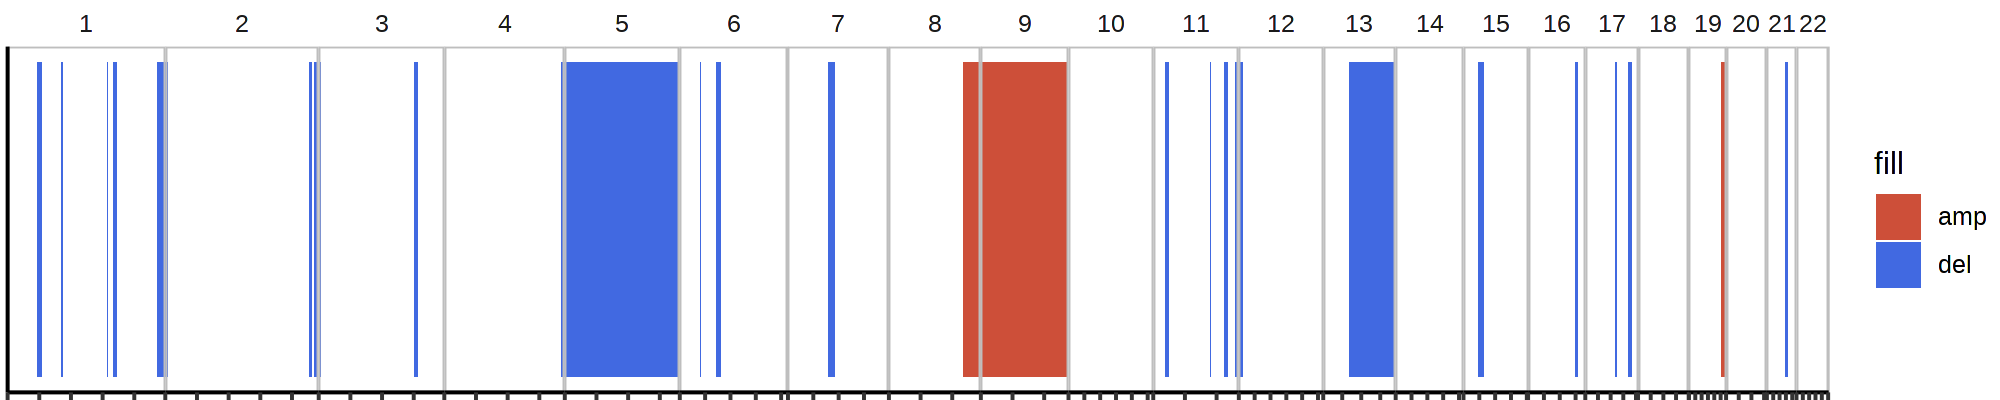

In [372]:
rbind(
    segs_exp %>% filter(cnv_state != 'neu'),
    segs_allele %>% filter(cnv_state != 'neu')
) %>%
ggplot(
) +
geom_rect(
    data = chrom_sizes,
    aes(xmin = 0, xmax = size, ymin = -0.5, ymax = 0.5, fill = NA)
) +
geom_rect(
    aes(xmin = seg_start, xmax = seg_end, ymin = -0.5, ymax = 0.5, fill = cnv_state)
) +
theme_classic() +
theme(
    panel.spacing = unit(0, 'mm'),
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_blank(),
    strip.text.y = element_text(angle = 0),
    axis.text = element_blank(),
    plot.margin = margin(0, 0, 0, 0),
    axis.title.x = element_blank(),
    axis.ticks.y = element_blank()
) +
facet_grid(~CHROM, space = 'free_x', scale = 'free') +
scale_fill_manual(values = c('neu' = 'white', numbat:::cnv_colors[names(numbat:::cnv_colors) != 'neu'])) +
scale_x_continuous(expand = expansion(add = 0))

Joining, by = "gene"



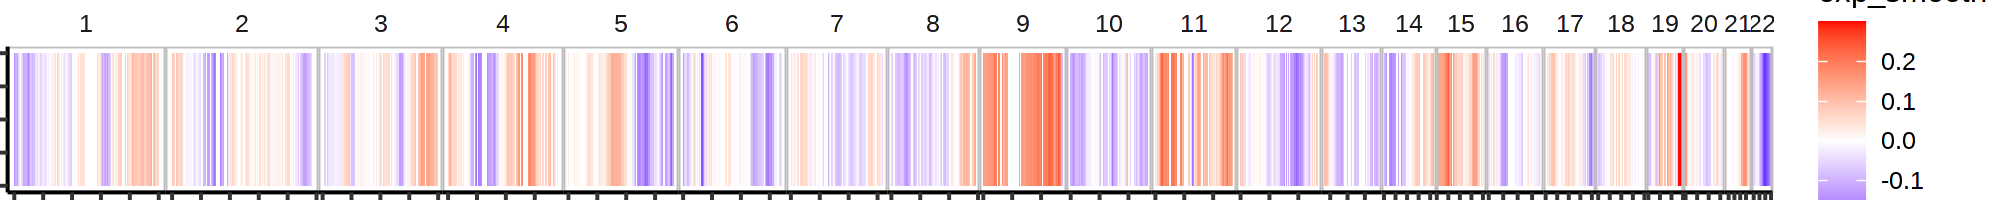

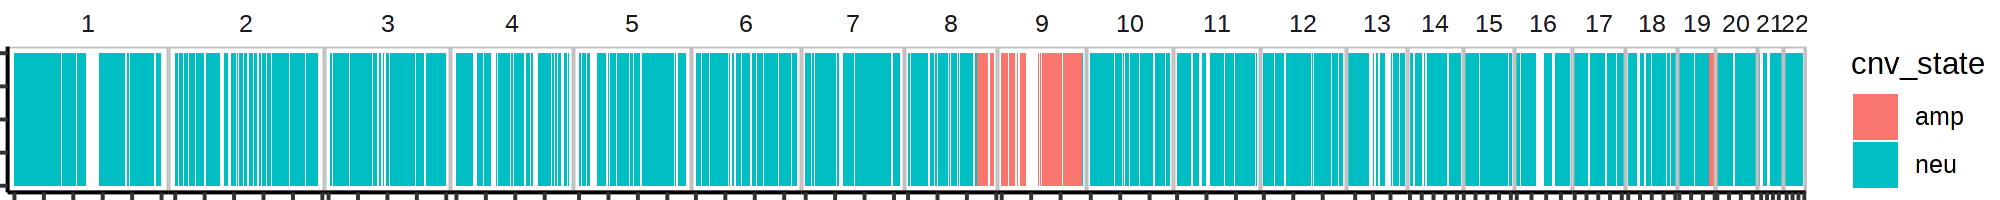

In [324]:
options(repr.plot.width = 10, repr.plot.height = 1, repr.plot.res = 200)

w = 0.3


ggplot(
    gexp.long
) +
geom_rect(
    aes(xmin = gene_start, xmax = gene_end, ymin = -0.5, ymax = 0.5, fill = exp_smooth)
) +
theme_classic() +
theme(
    panel.spacing = unit(0, 'mm'),
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_blank(),
    strip.text.y = element_text(angle = 0),
    axis.text = element_blank(),
    plot.margin = margin(0, 0, 0, 0),
    axis.title.x = element_blank()
) +
facet_grid(~CHROM, space = 'free_x', scale = 'free_x') +
scale_fill_gradient2(low = 'blue', mid = 'white', high = 'red', midpoint = 0, limits = c(-w, w), oob = scales::oob_squish)


ggplot(
    gexp.long
) +
geom_rect(
    aes(xmin = gene_start, xmax = gene_end, ymin = -0.5, ymax = 0.5, fill = cnv_state)
) +
theme_classic() +
theme(
    panel.spacing = unit(0, 'mm'),
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_blank(),
    strip.text.y = element_text(angle = 0),
    axis.text = element_blank(),
    plot.margin = margin(0, 0, 0, 0),
    axis.title.x = element_blank()
) +
facet_grid(~CHROM, space = 'free_x', scale = 'free_x') 

# Allele

In [204]:
options(repr.plot.width = 9, repr.plot.height = 4, repr.plot.res = 200)

hb[[sample]]$plotAlleleProfile() ## visualize individual SNPs

In [301]:
hb = c()

In [313]:
options(warn = -1)
R.utils::sourceDirectory('~/HoneyBADGER/R')
options(warn = 0)
hb[[sample]] <- new('HoneyBADGER', name='test')

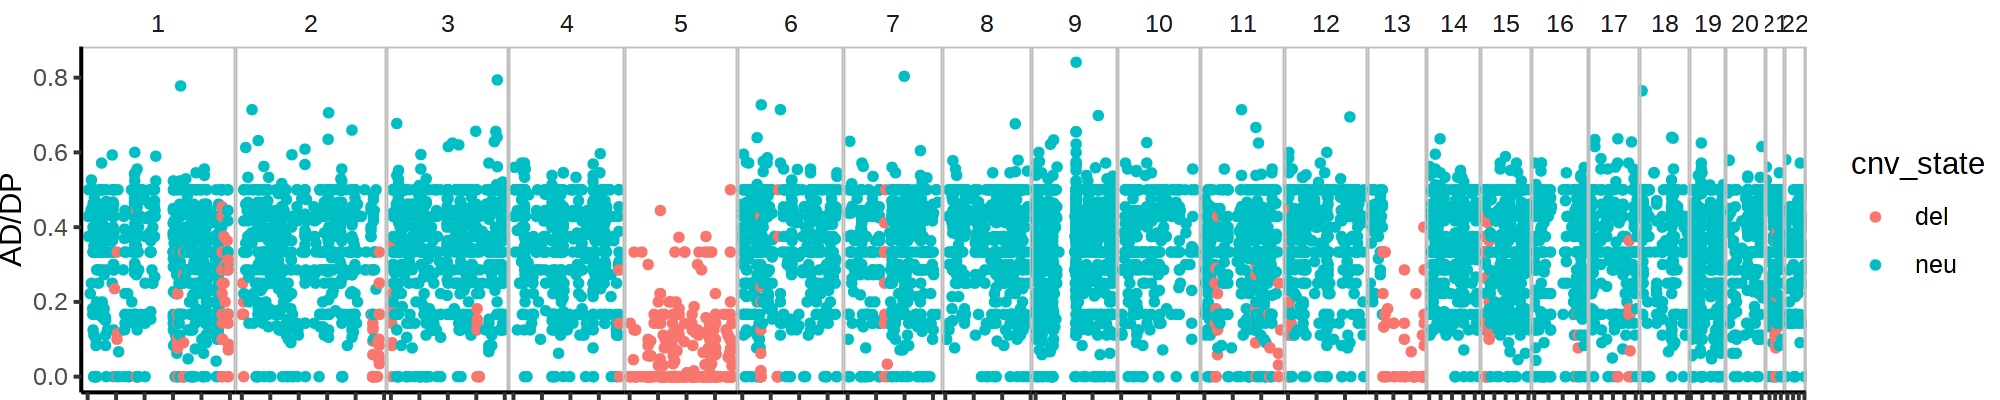

In [338]:
options(repr.plot.width = 10, repr.plot.height = 2, repr.plot.res = 200)

ggplot(
    snps %>% filter(DP > 5)
) +
geom_point(
    aes(x = POS, y = AD/DP, color = cnv_state),
    size = 1
) +
theme_classic() +
theme(
    panel.spacing = unit(0, 'mm'),
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_blank(),
    axis.text.x = element_blank(),
    plot.margin = margin(0, 0, 0, 0),
    axis.title.x = element_blank()
) +
facet_grid(~CHROM, space = 'free_x', scale = 'free_x') 

In [360]:
options(warn = -1)
R.utils::sourceDirectory('~/HoneyBADGER/R')
options(warn = 0)
hb <- new('HoneyBADGER', name='test')

In [381]:
retestIdentifiedCnvs

ERROR: Error in eval(expr, envir, enclos): object 'retestIdentifiedCnvs' not found


In [194]:
hb$retestIdentifiedCnvs(retestBoundGenes = TRUE, retestBoundSnps = FALSE, verbose=FALSE)

## look at final results
results <- hb$summarizeResults(geneBased=TRUE, alleleBased=FALSE)
print(head(results[,1:5]))

ERROR NO GENES AFFECTED BY CNVS IDENTIFIED! Run calcGexpCnvBoundaries()? 

ERROR: Error in rowMeans(amp.gexp.prob): 'x' must be an array of at least two dimensions


In [306]:
trees <- hb$visualizeResults(geneBased=TRUE, alleleBased=FALSE, details=TRUE, margins=c(25,15))

ERROR: Error in hclust(dist(t(df^(power))), method = "ward.D"): must have n >= 2 objects to cluster


# Single cells

In [451]:
sample = '27522_Relapse_2'

hb[[sample]]$setMvFit(verbose=TRUE)

region = GenomicRanges::GRanges(
    seqnames = 'chr22',
    IRanges::IRanges(start = 0,
        end = 50818468)
)

res = hb[[sample]]$calcCombCnvProb(region = region, verbose = T, quiet = F)

Modeling expected variance ... Done!restricting to 266 genes in region 


Assessing posterior probability of CNV in region ... 


with 266 genes ... 

and 67 snps ... 

... within 44 genes ... 


Converting to multi-dimensional arrays...

Aggregating data to list...

Initializing model...



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 74659
   Unobserved stochastic nodes: 45093
   Total graph size: 340194

Initializing model



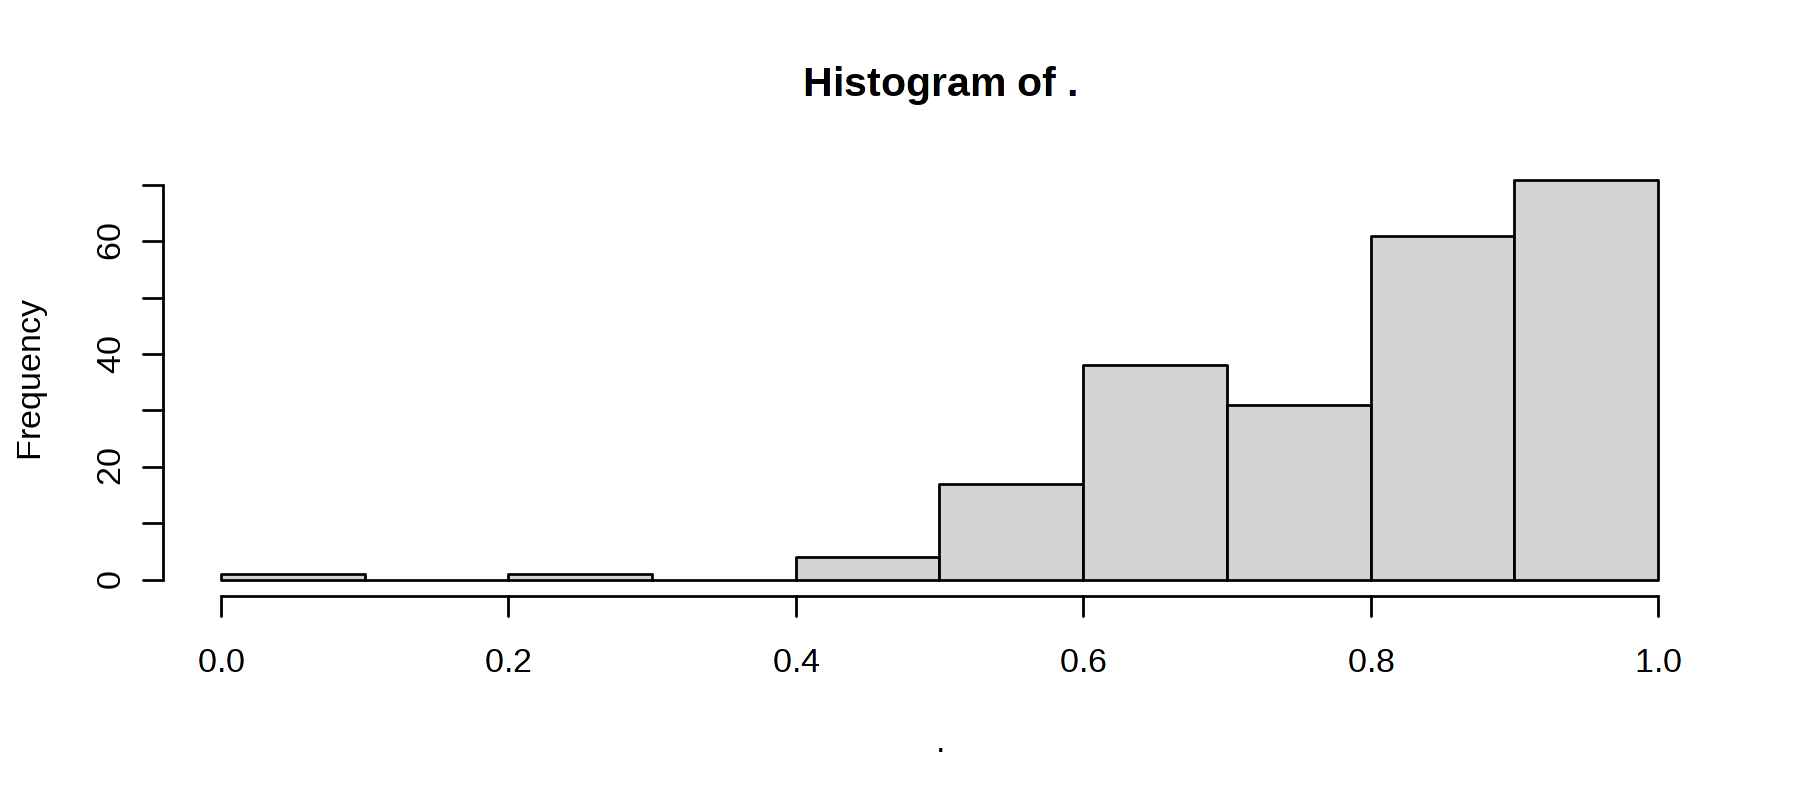

In [454]:
res$`posterior probability of deletion` %>% hist

In [554]:
ref_types = c('NK', 'Macrophage', 'CD4+T', 'CD8+T', 'Myeloid', 'Monocyte', 'B', 'Plasma', 'Dendritic')

hb_full = c()

for (sample in samples) {
    
    message(sample)
    
    cells = cell_annot[[sample]] %>% pull(cell)

    exp_mat = scale(count_mat[[sample]], center=FALSE, scale=colSums(count_mat[[sample]])) 
    
    df_het = df[[sample]] %>%
        filter(CHROM != 'X') %>%
        filter(GT %in% c('0|1', '1|0')) %>%
        filter(cell %in% cells) %>% 
        mutate(snp_id = paste0(CHROM, ':', POS)) %>%
        mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
        distinct(cell, snp_id, .keep_all = TRUE)

    alt.counts = df_het %>%
        data.table::dcast(snp_id ~ cell, value.var = 'AD', fill = 0) %>%
        tibble::column_to_rownames('snp_id') %>%
        as.matrix

    total.counts = df_het %>%
        data.table::dcast(snp_id ~ cell, value.var = 'DP', fill = 0) %>%
        tibble::column_to_rownames('snp_id') %>%
        as.matrix

    hb_full[[sample]] <- new('HoneyBADGER', name='test')
    hb_full[[sample]]$setGexpMats(log(exp_mat[,cells] * 1e6 + 1), log(rowMeans(numbat::ref_hca[,ref_types]) * 1e6 + 1), mart.obj, filter=TRUE, scale=TRUE, verbose=TRUE)
    hb_full[[sample]]$setMvFit(verbose=TRUE)
    hb_full[[sample]]$setAlleleMats(r.init=alt.counts[,cells], n.sc.init=total.counts[,cells], het.deviance.threshold = -1, n.cores=20)
    hb_full[[sample]]$setGeneFactors(txdb)
}

27522_Relapse_2



Initializing expression matrices ... 
15445 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 15445 genes and 3499 cells ... 



Batch submitting query [=======>-----------------------]  25% eta: 14s

Batch submitting query [===============>---------------]  50% eta: 13s

Batch submitting query [======================>--------]  75% eta:  5s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 3499 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
120431 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-23 10:43:26 AM 
>> identifying nearest features...		 2021-12-23 10:43:26 AM 
>> calculating distance from peak to TSS...	 2021-12-23 10:43:26 AM 
>> assigning genomic annotation...		 2021-12-23 10:43:26 AM 
>> assigning chromosome lengths			 2021-12-23 10:43:28 AM 
>> done...					 2021-12-23 10:43:28 AM 
Done mapping snps to genes! 


58408_Primary



Initializing expression matrices ... 
15445 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 15445 genes and 3880 cells ... 



Batch submitting query [=======>-----------------------]  25% eta: 35s

Batch submitting query [===============>---------------]  50% eta: 27s

Batch submitting query [======================>--------]  75% eta:  9s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 3880 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
101193 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-23 10:47:10 AM 
>> identifying nearest features...		 2021-12-23 10:47:10 AM 
>> calculating distance from peak to TSS...	 2021-12-23 10:47:11 AM 
>> assigning genomic annotation...		 2021-12-23 10:47:11 AM 
>> assigning chromosome lengths			 2021-12-23 10:47:13 AM 
>> done...					 2021-12-23 10:47:13 AM 
Done mapping snps to genes! 


47491_Primary



Initializing expression matrices ... 
14884 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 14884 genes and 1465 cells ... 



Batch submitting query [=========>---------------------]  33% eta:  1m

Batch submitting query [====================>----------]  67% eta: 17s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 1465 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
88360 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-23 10:49:17 AM 
>> identifying nearest features...		 2021-12-23 10:49:17 AM 
>> calculating distance from peak to TSS...	 2021-12-23 10:49:18 AM 
>> assigning genomic annotation...		 2021-12-23 10:49:18 AM 
>> assigning chromosome lengths			 2021-12-23 10:49:20 AM 
>> done...					 2021-12-23 10:49:20 AM 
Done mapping snps to genes! 


37692_Primary



Initializing expression matrices ... 
15067 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 15067 genes and 3078 cells ... 



Batch submitting query [=======>-----------------------]  25% eta: 43s

Batch submitting query [===============>---------------]  50% eta: 16s

Batch submitting query [======================>--------]  75% eta:  6s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 3078 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
80033 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-23 10:51:58 AM 
>> identifying nearest features...		 2021-12-23 10:51:58 AM 
>> calculating distance from peak to TSS...	 2021-12-23 10:51:59 AM 
>> assigning genomic annotation...		 2021-12-23 10:51:59 AM 
>> assigning chromosome lengths			 2021-12-23 10:52:01 AM 
>> done...					 2021-12-23 10:52:01 AM 
Done mapping snps to genes! 


59114_Relapse_1



Initializing expression matrices ... 
15517 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 15517 genes and 3413 cells ... 



Batch submitting query [=======>-----------------------]  25% eta:  4s

Batch submitting query [===============>---------------]  50% eta:  3s

Batch submitting query [======================>--------]  75% eta:  4s
                                                                      



Done setting initial expression matrices! 
Initializing allele matrices ... 
Creating in-silico bulk ... 
using 3413 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
121584 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-23 10:56:04 AM 
>> identifying nearest features...		 2021-12-23 10:56:04 AM 
>> calculating distance from peak to TSS...	 2021-12-23 10:56:05 AM 
>> assigning genomic annotation...		 2021-12-23 10:56:05 AM 
>> assigning chromosome lengths			 2021-12-23 10:56:08 AM 
>> done...					 2021-12-23 10:56:08 AM 
Done mapping snps to genes! 


In [557]:
for (sample in samples) {
    saveRDS(hb_full[[sample]], glue('~/results/benchmark/hb_{sample}.rds'))
}

In [556]:
cell_annot[samples] %>% lapply(dim)

$`27522_Relapse_2`
[1] 3499    4

$`58408_Primary`
[1] 3880    4

$`47491_Primary`
[1] 1465    4

$`37692_Primary`
[1] 3078    4

$`59114_Relapse_1`
[1] 3413    4

In [461]:
cells_subset = cells[1:10]

In [506]:
options(warn = -1)
R.utils::sourceDirectory('~/HoneyBADGER/R')
options(warn = 0)

## Add to existing hb object
hb_test <- new('HoneyBADGER', name='test')
hb_test$setGexpMats(log(exp_mat[,cells_subset] * 1e6 + 1), log(rowMeans(numbat::ref_hca[,'Plasma']) * 1e6 + 1), mart.obj, filter=TRUE, scale=TRUE, verbose=TRUE)

## Add to existing hb object
hb_test$setAlleleMats(r.init=alt.counts[,cells_subset], n.sc.init=total.counts[,cells_subset], het.deviance.threshold = -1, n.cores=20)
hb_test$setGeneFactors(txdb)

Initializing expression matrices ... 
8476 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 8476 genes and 10 cells ... 
Done setting initial expression matrices! 


In [466]:
hb_test$setMvFit(verbose=TRUE)

region = GenomicRanges::GRanges(
    seqnames = 'chr22',
    IRanges::IRanges(start = 0,
        end = 50818468)
)

res = hb_test$calcCombCnvProb(region = region, verbose = T, quiet = F)

Modeling expected variance ... Done!restricting to 183 genes in region 


Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
ERROR! ONLY 0 SNPS IN REGION! 




In [499]:
cm = count_mat[[sample]]
exp_mat = scale(cm, center=FALSE, scale=colSums(cm)) 

alt.counts = df[[sample]] %>% 
    filter(CHROM != 'X') %>%
    filter(GT %in% c('0|1', '1|0')) %>%
    mutate(snp_id = paste0(CHROM, ':', POS)) %>%
    mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
    distinct(cell, snp_id, .keep_all = TRUE) %>%
    dcast(snp_id ~ cell, value.var = 'AD', fill = 0) %>%
    tibble::column_to_rownames('snp_id') %>%
    as.matrix

total.counts = df[[sample]] %>%
    filter(CHROM != 'X') %>%
    filter(GT %in% c('0|1', '1|0')) %>%
    mutate(snp_id = paste0(CHROM, ':', POS)) %>%
    mutate(snp_id = factor(snp_id, unique(snp_id))) %>%
    distinct(cell, snp_id, .keep_all = TRUE) %>%
    dcast(snp_id ~ cell, value.var = 'DP', fill = 0) %>%
    tibble::column_to_rownames('snp_id') %>%
    as.matrix

In [507]:
options(warn = -1)
R.utils::sourceDirectory('~/HoneyBADGER/R')
options(warn = 0)

## Add to existing hb object
hb_test <- new('HoneyBADGER', name='test')
hb_test$setGexpMats(log(exp_mat * 1e6 + 1), log(numbat::ref_hca[,'Plasma'] * 1e6 + 1), mart.obj, filter=TRUE, scale=TRUE, verbose=TRUE)
hb_test$setMvFit(verbose=TRUE)

## Add to existing hb object
hb_test$setAlleleMats(r.init=alt.counts, n.sc.init=total.counts, het.deviance.threshold = -1, n.cores=20)
hb_test$setGeneFactors(txdb)

Initializing expression matrices ... 
12734 genes passed filtering ... 
Scaling coverage ... 
Normalizing gene expression for 12734 genes and 3499 cells ... 
Done setting initial expression matrices! 
Modeling expected variance ... Done!Initializing allele matrices ... 
Creating in-silico bulk ... 
using 3499 cells ... 
Filtering for putative heterozygous snps ... 
allowing for a -1 deviation from the expected 0.5 heterozygous allele fraction ... 
must have coverage in at least 3 cells ... 
120431 heterozygous SNPs identified 
Setting composite lesser allele count ... 
Done setting initial allele matrices! 
Mapping snps to genes ... 
>> preparing features information...		 2021-12-22 05:59:29 PM 
>> identifying nearest features...		 2021-12-22 05:59:29 PM 
>> calculating distance from peak to TSS...	 2021-12-22 05:59:29 PM 
>> assigning genomic annotation...		 2021-12-22 05:59:29 PM 
>> assigning chromosome lengths			 2021-12-22 05:59:31 PM 
>> done...					 2021-12-22 05:59:31 PM 
Done 

In [531]:
cells = cell_annot[[sample]] %>%
#     filter(cell_type == 'Plasma') %>%
    pull(cell)

In [530]:
split(cells, ceiling(seq_along(cells)/60)) %>% length

[1] 59

In [532]:
res = mclapply(
        mc.cores = 64,
        split(cells, ceiling(seq_along(cells)/60)),
        function(cells_subset) {

            res = hb_test$calcCombCnvProb(
                region = region,
                r.sub = hb_test$r.maf[,cells_subset],
                n.sc = hb_test$n.sc[,cells_subset],
                verbose = T, 
                quiet = F,
                filter = T
            )

            data.frame(
                cell = names(res$`posterior probability of amplification`),
                p_amp = res$`posterior probability of amplification`,
                p_del = res$`posterior probability of deletion`
            )
        }
    ) %>%
    bind_rows()

Joining, by = "cell"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



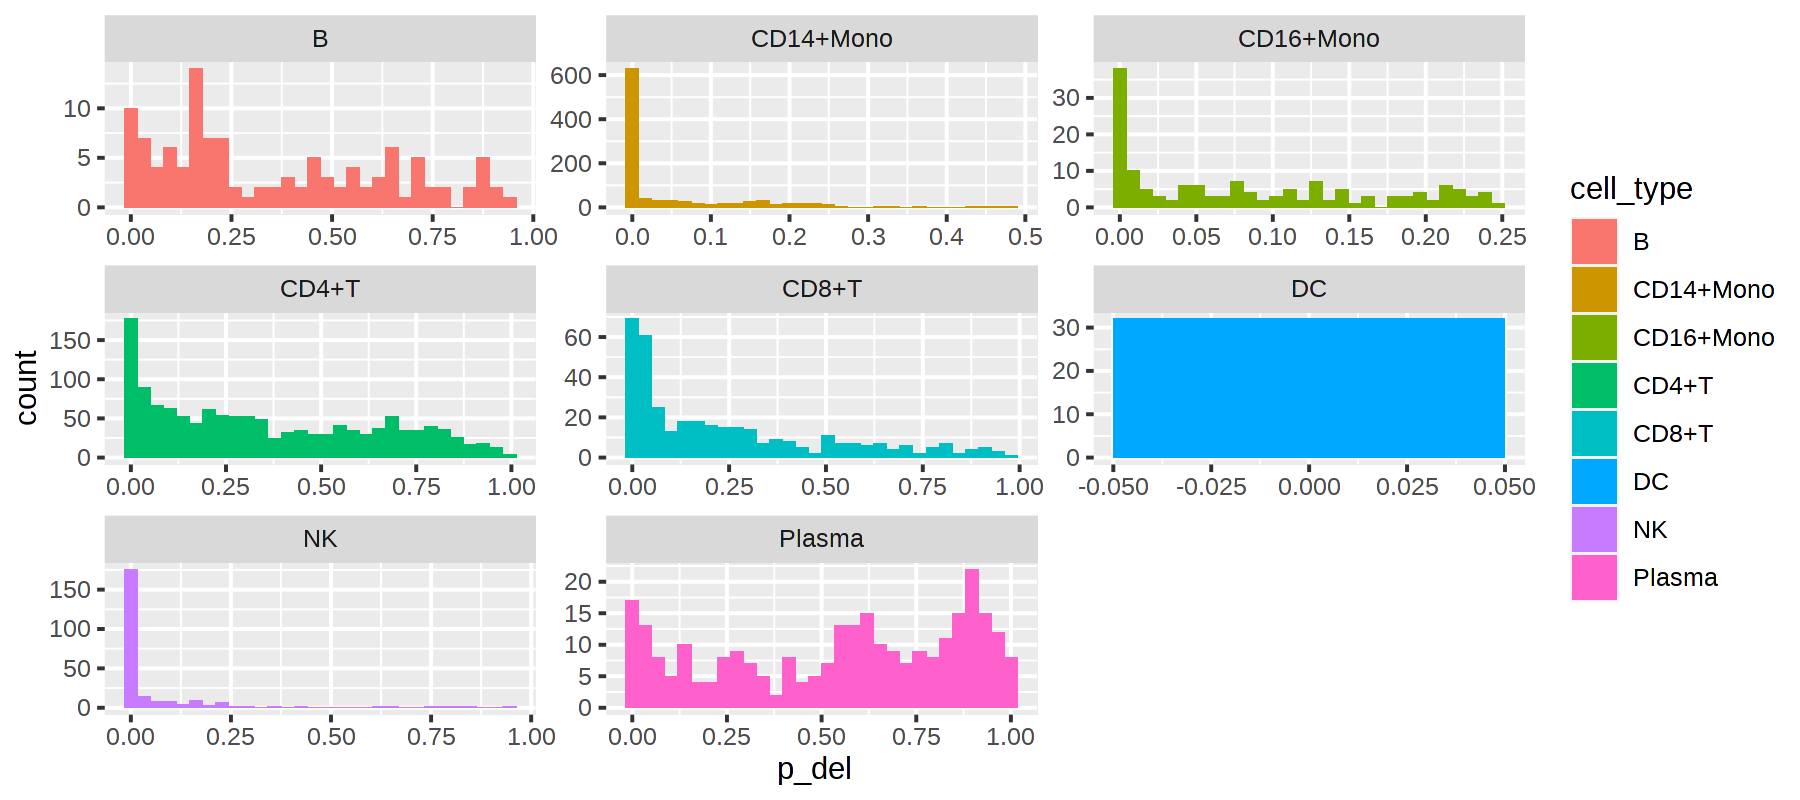

In [539]:
# give avged ref exp profile?
ggplot(
    res %>% left_join(cell_annot[[sample]]),
    aes(x = p_del, fill = cell_type)
) +
geom_histogram() +
facet_wrap(~cell_type, scale = 'free')